<a href="https://colab.research.google.com/github/ManuelWalker/yolov3/blob/master/VIS_Deep_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bern Winter School on Advanced Machine Learning, 07 Oct 2021**

# Lecture on Neural Network visualization and interpretability


The goal of these lessons is to go beyond the starting "Split train-test / model.compile / model.fit" pipeline. Trying to inspect more the model we can:

- Be more confident about correct implementation and start building an intuition that can guide development 

- Find sources of errors that can point out mistakes in the datasets

With this in mind we will:

- Visualize the "forward pass" of a neural net
- Show how to use gradients to understand why the neural net is taking certain decisions

In the process, we will find some tricks for Tensorflow 2.0 .

## 1.1 Data and model definition

In [1]:
import tensorflow  as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt

2.6.0


In [2]:
(x_train_2d, y_train), (x_val_2d, y_val) = tf.keras.datasets.mnist.load_data()  
n_train = x_train_2d.shape[0]
n_val = x_val_2d.shape[0]
x_train_2d = x_train_2d/255.0
x_val_2d = x_val_2d/255.0
x_train = x_train_2d[..., np.newaxis]  
x_val = x_val_2d[..., np.newaxis]  
print ('train: data shape', x_train_2d.shape, 'label shape', y_train.shape)
print ('test: data shape', x_val_2d.shape, 'label shape', y_val.shape)

11501568/11490434 [==============================] - 0s 0us/step
train: data shape (60000, 28, 28) label shape (60000,)
test: data shape (10000, 28, 28) label shape (10000,)


In [3]:
inputs=tf.keras.Input(shape=(28,28,1))

x=tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same')(inputs)
x=tf.keras.layers.ReLU()(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)

x=tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same')(x)
x=tf.keras.layers.ReLU()(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)

x=tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same')(x)
x=tf.keras.layers.ReLU()(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)

x=tf.keras.layers.Flatten()(x)

x=tf.keras.layers.Dense(32,activation='relu')(x)
x=tf.keras.layers.Dense(10,activation=None)(x)

model=tf.keras.Model(inputs=[inputs],outputs=[x])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0     

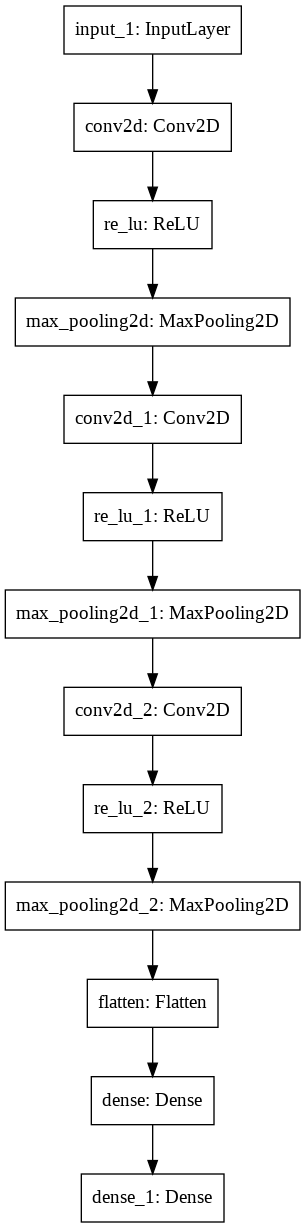

In [4]:
model.summary()
tf.keras.utils.plot_model(model)

In [5]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [6]:
model.fit(x_train,y_train, epochs=10, validation_data=(x_val,y_val), batch_size=64)

Epoch 1/10
938/938 [==============================] - 37s 7ms/step - loss: 0.2552 - accuracy: 0.9226 - val_loss: 0.0732 - val_accuracy: 0.9773
Epoch 2/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0782 - accuracy: 0.9761 - val_loss: 0.0466 - val_accuracy: 0.9856
Epoch 3/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0548 - accuracy: 0.9826 - val_loss: 0.0411 - val_accuracy: 0.9875
Epoch 4/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0428 - accuracy: 0.9868 - val_loss: 0.0414 - val_accuracy: 0.9869
Epoch 5/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0373 - accuracy: 0.9887 - val_loss: 0.0308 - val_accuracy: 0.9902
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0311 - accuracy: 0.9902 - val_loss: 0.0417 - val_accuracy: 0.9851
Epoch 7/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0270 - accuracy: 0.9910 - val_loss: 0.0369 - val_accuracy: 0.9874
Epoch

## 1.2 Model inspection

In Tensorflow-2, our model is a subclass of the model class. 

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/engine/training.py

This means that you can use all methods and attributes that are automatically initialized for us.

In [7]:
dir(type(model))

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_autographed_call',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_cast_single_input',
 '_check_call_args',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_compile_was_called',
 '_compute_dtype',
 '_compute_tensor_usage_count',
 '_configure_steps_per_execution',
 '_conform_to_reference_input',
 '_dedup_weights',
 '_deferred_depe

Let's inspect first of all the activations during a forward pass. We can leverage "model.layers" to get access to the model layers and its internal variables: 

In [8]:
for layer in model.layers:
    print(f'Layer name: {layer.name}')
    print(f'Is it trainable?: {layer.trainable}')
    print(type(layer))
    for var  in layer.trainable_variables:
        print(var.name, var.shape)
    print()

Layer name: input_1
Is it trainable?: True
<class 'keras.engine.input_layer.InputLayer'>

Layer name: conv2d
Is it trainable?: True
<class 'keras.layers.convolutional.Conv2D'>
conv2d/kernel:0 (3, 3, 1, 16)
conv2d/bias:0 (16,)

Layer name: re_lu
Is it trainable?: True
<class 'keras.layers.advanced_activations.ReLU'>

Layer name: max_pooling2d
Is it trainable?: True
<class 'keras.layers.pooling.MaxPooling2D'>

Layer name: conv2d_1
Is it trainable?: True
<class 'keras.layers.convolutional.Conv2D'>
conv2d_1/kernel:0 (3, 3, 16, 32)
conv2d_1/bias:0 (32,)

Layer name: re_lu_1
Is it trainable?: True
<class 'keras.layers.advanced_activations.ReLU'>

Layer name: max_pooling2d_1
Is it trainable?: True
<class 'keras.layers.pooling.MaxPooling2D'>

Layer name: conv2d_2
Is it trainable?: True
<class 'keras.layers.convolutional.Conv2D'>
conv2d_2/kernel:0 (3, 3, 32, 32)
conv2d_2/bias:0 (32,)

Layer name: re_lu_2
Is it trainable?: True
<class 'keras.layers.advanced_activations.ReLU'>

Layer name: max_po

How can we access the values of the trained variables? 

In [9]:
for layer in model.layers:
    if layer.name=='conv2d':
      for var  in layer.trainable_variables:
          if var.name=='conv2d/kernel:0':
              kernels=var.numpy()
print(kernels.shape)

(3, 3, 1, 16)


## 1.3 Brief recap on filters


Before visualizing more the values we computed, let's review how the Sobel filter https://en.wikipedia.org/wiki/Sobel_operator can work as an edge detector. We can build a Sobel filter using Tensorflow. Although probably OpenCV is a better choice, we will use the same pipeline more times during the tutorial :

kernel:0 (3, 3, 1, 1)
bias:0 (1,)


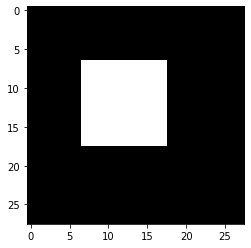

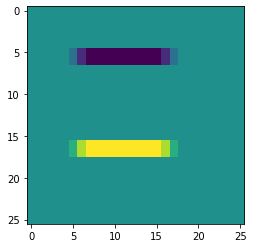

In [10]:
square=np.zeros((28,28))
for i in range(7,18):
    for j in range(7,18):
        square[i,j]=1.0
plt.imshow(square,cmap='gray')

filter_values=np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]]).astype(np.float32)
filter_values=filter_values[...,np.newaxis,np.newaxis]

conv=tf.keras.layers.Conv2D(filters=1,kernel_size=3)
conv.build(input_shape=(1,28,28,1))

for var in conv.trainable_variables:
    print(var.name, var.shape)
    if var.name=='bias:0':
        var.assign([0])
    if var.name=='kernel:0':
        var.assign(filter_values)

result=conv(square.reshape(1,28,28,1))
plt.figure()
plt.imshow(result[0,:,:,0])

The important message here is that a filter, considered in an astract way **acts on subsets of the image and for each patch it provides a single number** saying if that feature was active or not. This concept can be exemplified looking at what are called feature maps / internal representations in the first convolutional layer.

## 1.4 The first hidden layer

In [11]:
for layer in model.layers:
    if layer.name=='conv2d':
      for var  in layer.trainable_variables:
          if var.name=='conv2d/kernel:0':
              kernels=var.numpy()
print(kernels.shape)

(3, 3, 1, 16)


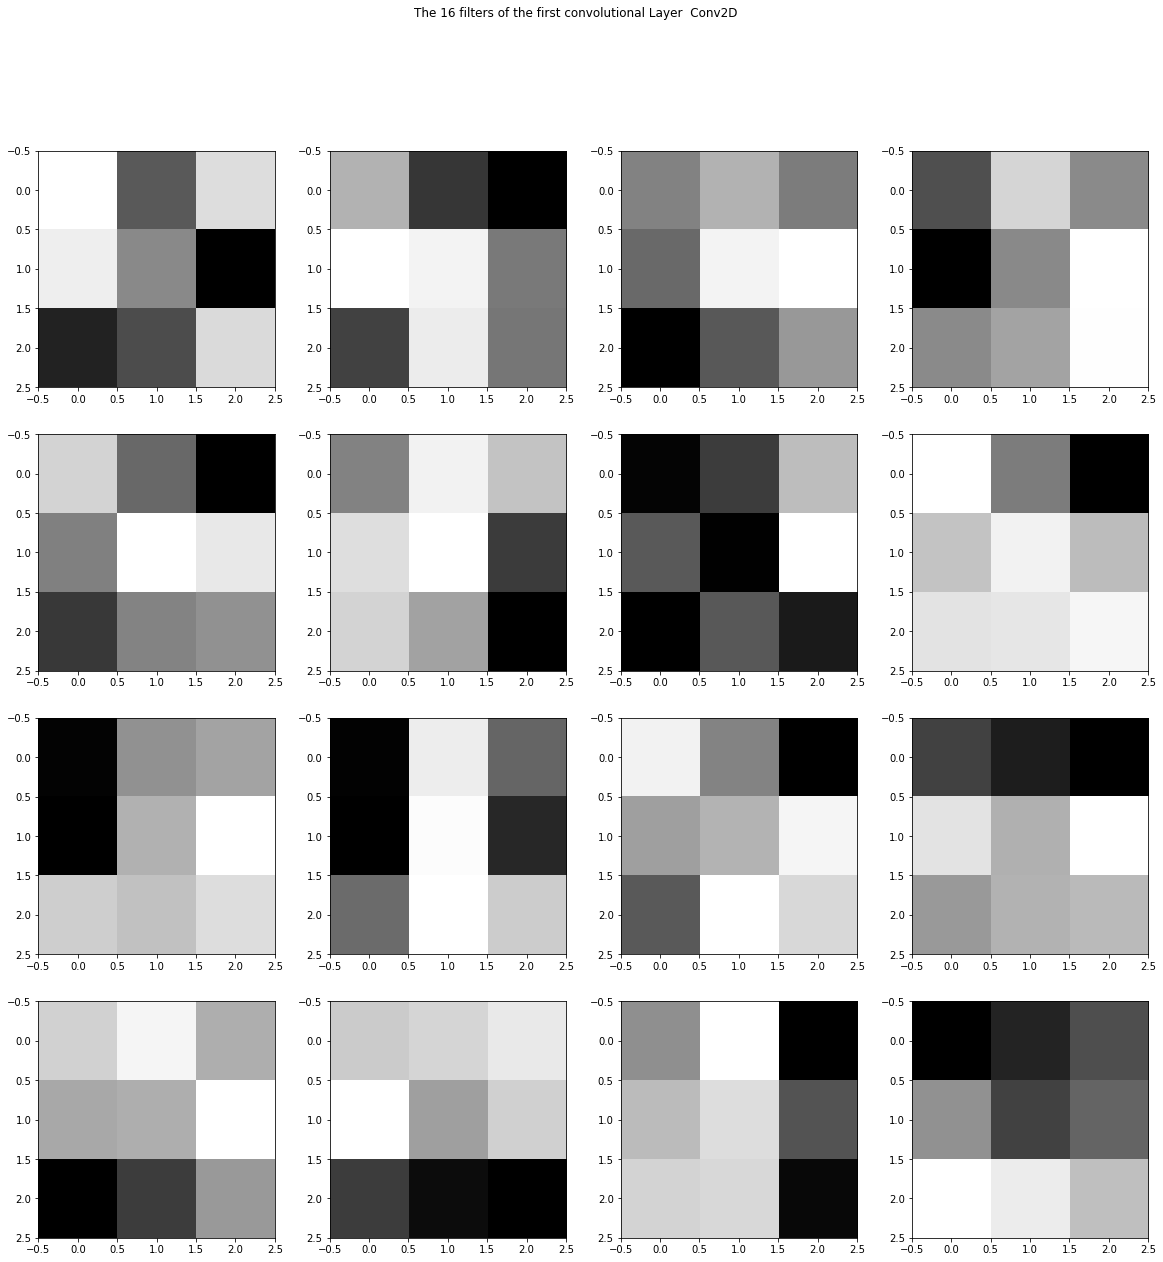

In [14]:
n=16
ilayer = 'Conv2D'
fig,ax=plt.subplots(int(n/4),4,figsize=(20,int(n/4)*5))
fig.suptitle('The 16 filters of the first convolutional Layer  '+str(ilayer))
c=0
for ich in range(n):
    _=ax[c//4,c%4].imshow(kernels[:,:,0,c], cmap='gray')
    c+=1

Ok, we have the filterst, but how do we visualize internal activations??? 

To visualize internal activations here we build a new Keras Model, where the outputs are taken from the starting model model.

In [15]:
names=[layer.name for layer in model.layers[1:]]
print(names)
vis_model=tf.keras.Model(model.input, outputs=[layer.output for layer in model.layers[1:]])

['conv2d', 're_lu', 'max_pooling2d', 'conv2d_1', 're_lu_1', 'max_pooling2d_1', 'conv2d_2', 're_lu_2', 'max_pooling2d_2', 'flatten', 'dense', 'dense_1']


In [16]:
results=[]
inp = tf.constant(x_val[:15,...])  # create tf constant tensor

preds = vis_model(inp) # evaluate model output
results=[ pred.numpy() for pred in preds ]

Let's check model dimensions:

In [17]:
for name, result in zip(names,results):
    print(name,result.shape)

conv2d (15, 28, 28, 16)
re_lu (15, 28, 28, 16)
max_pooling2d (15, 14, 14, 16)
conv2d_1 (15, 14, 14, 32)
re_lu_1 (15, 14, 14, 32)
max_pooling2d_1 (15, 7, 7, 32)
conv2d_2 (15, 7, 7, 32)
re_lu_2 (15, 7, 7, 32)
max_pooling2d_2 (15, 3, 3, 32)
flatten (15, 288)
dense (15, 32)
dense_1 (15, 10)


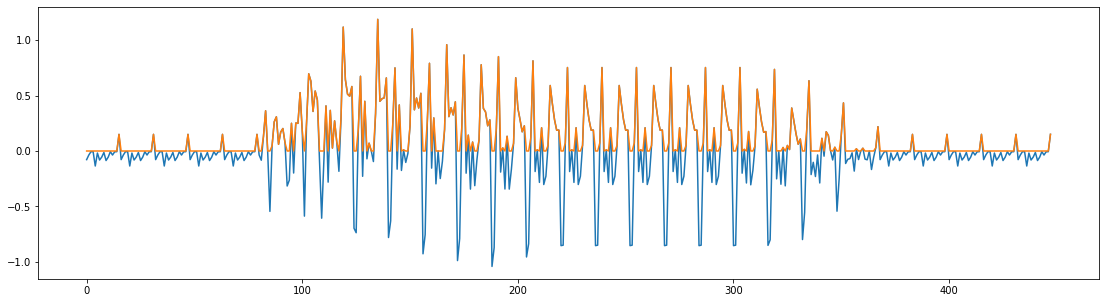

In [18]:
plt.figure(figsize=(19,5))
# Let's try to check for example what happens before and after a relu activation
plt.plot(results[0][0,7,:,:].flatten())
# Since we have a relu
plt.plot(results[1][0,7,:,:].flatten())

In [19]:
# Just a bit of postprocessing of the results

figures_relu={}
nchs=[16,32,32]
index_results=[1,4,7]

for il, nch, index_result in zip(range(3), nchs, index_results):
   print(il, nch, index_result)
   figures_relu[il]={}
   for ch in range(nch):
       figures_relu[il][ch]=results[index_result][...,ch]

0 16 1
1 32 4
2 32 7


<Figure size 432x288 with 0 Axes>

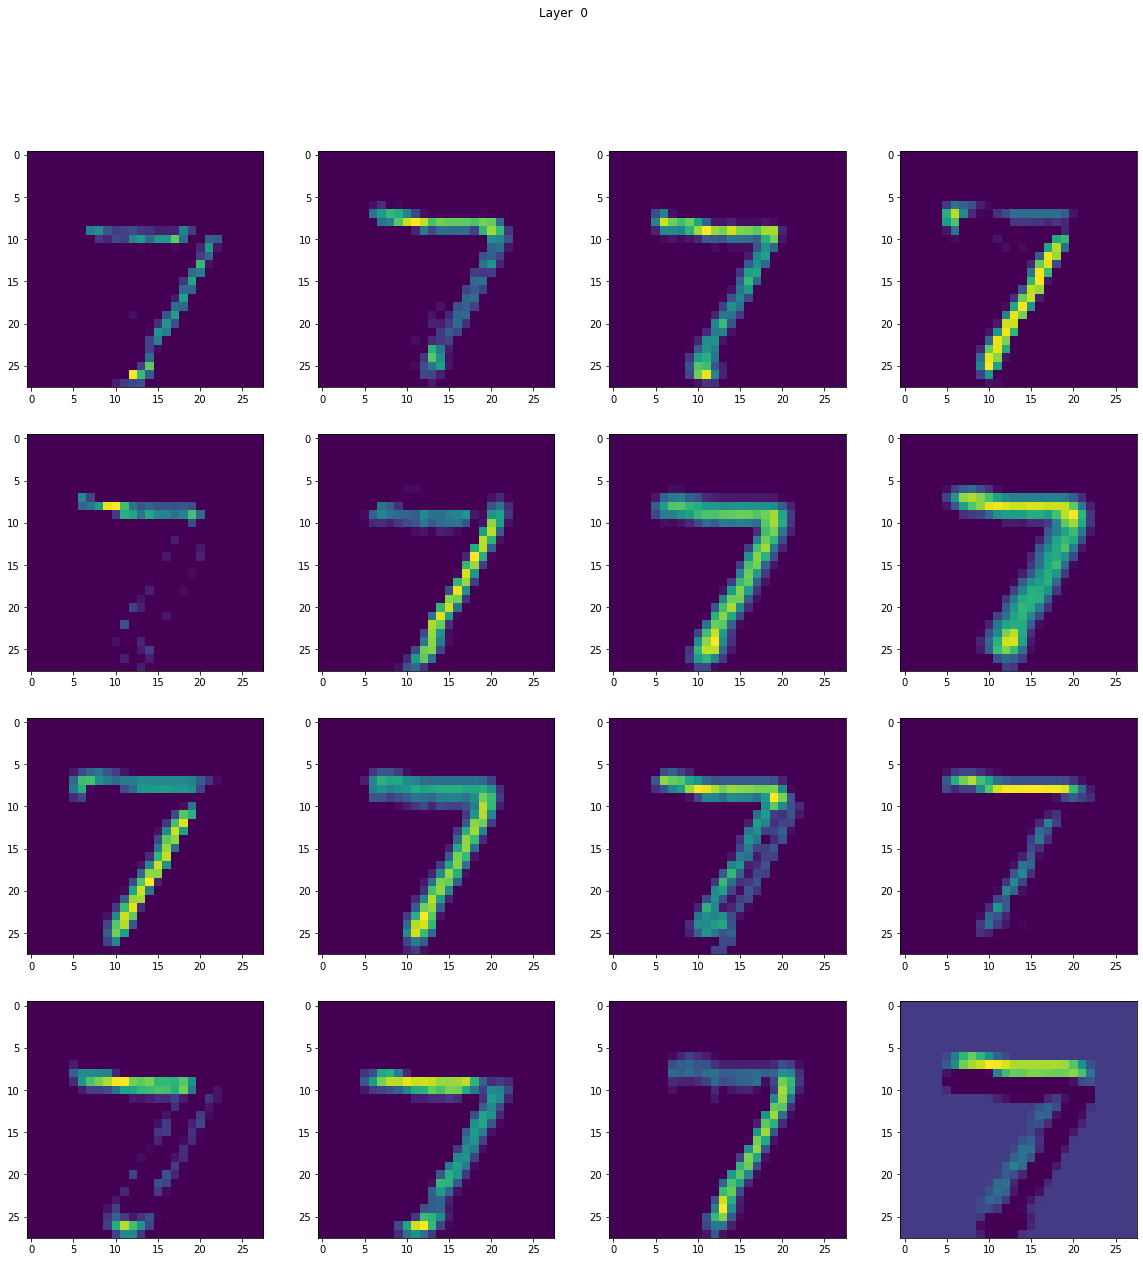

In [20]:
image=0
for ilayer in [0]:
    plt.figure()
    n=len(figures_relu[ilayer])
    fig,ax=plt.subplots(int(n/4),4,figsize=(20,int(n/4)*5))
    fig.suptitle('Layer  '+str(ilayer))
    c=0
    for ich in range(n):
        _=ax[c//4,c%4].imshow(figures_relu[ilayer][ich][image,...])
        c+=1

## 1.5 The second and third hidden layers

<Figure size 432x288 with 0 Axes>

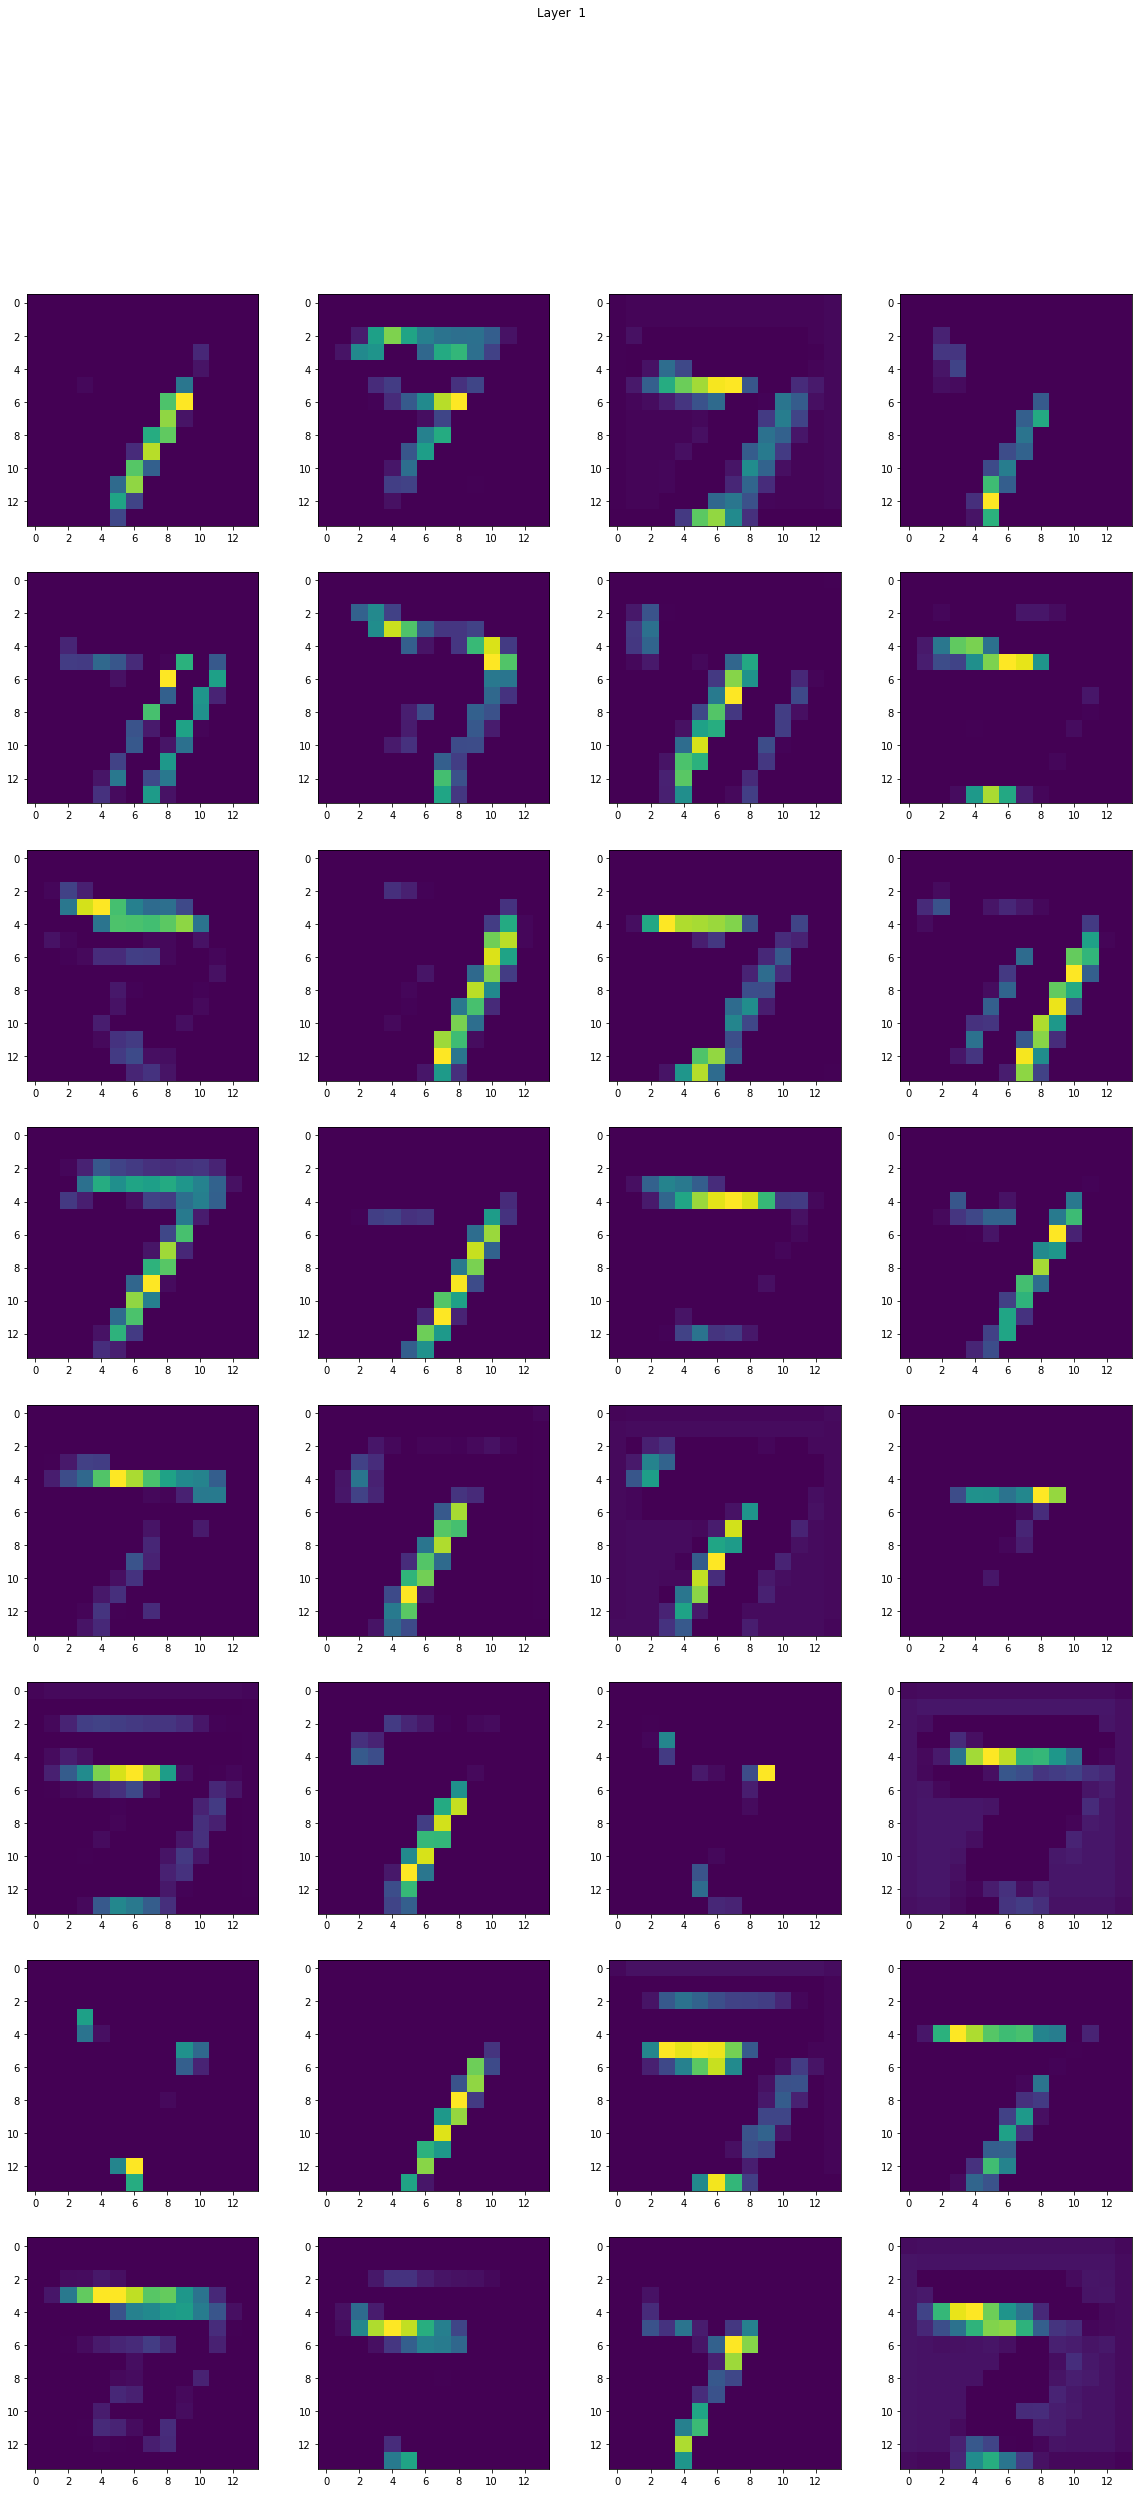

In [21]:
image=0
for ilayer in [1]:
    plt.figure()
    n=len(figures_relu[ilayer])
    fig,ax=plt.subplots(int(n/4),4,figsize=(20,int(n/4)*5))
    fig.suptitle('Layer  '+str(ilayer))
    c=0
    for ich in range(n):
        _=ax[c//4,c%4].imshow(figures_relu[ilayer][ich][image,...])
        c+=1

Note that:
*    Because of the downscaling and the combination of two filtering operations, the spatial dimension becomes smaller and each new "super-pixel" is detecting a feature from more pixels of the original image (this is also called the receptive field of that superpixel). 

*   The features in the second hidden layer are "features of features" and may detect more involved patterns. 

*   Since in the hidden layers the features detected can be more complicated, there is a bunch of possible patterns that can be detected and this is why the channel dimension has to increase.

*   We see also that, just from looking at the forward pass we know only when a feature is activated, but it is difficult to recognize the nature of the feature, especially in hidden layers.

All these aspects and abstraction becomes even more pronounced in the third convolutional layer:

<Figure size 432x288 with 0 Axes>

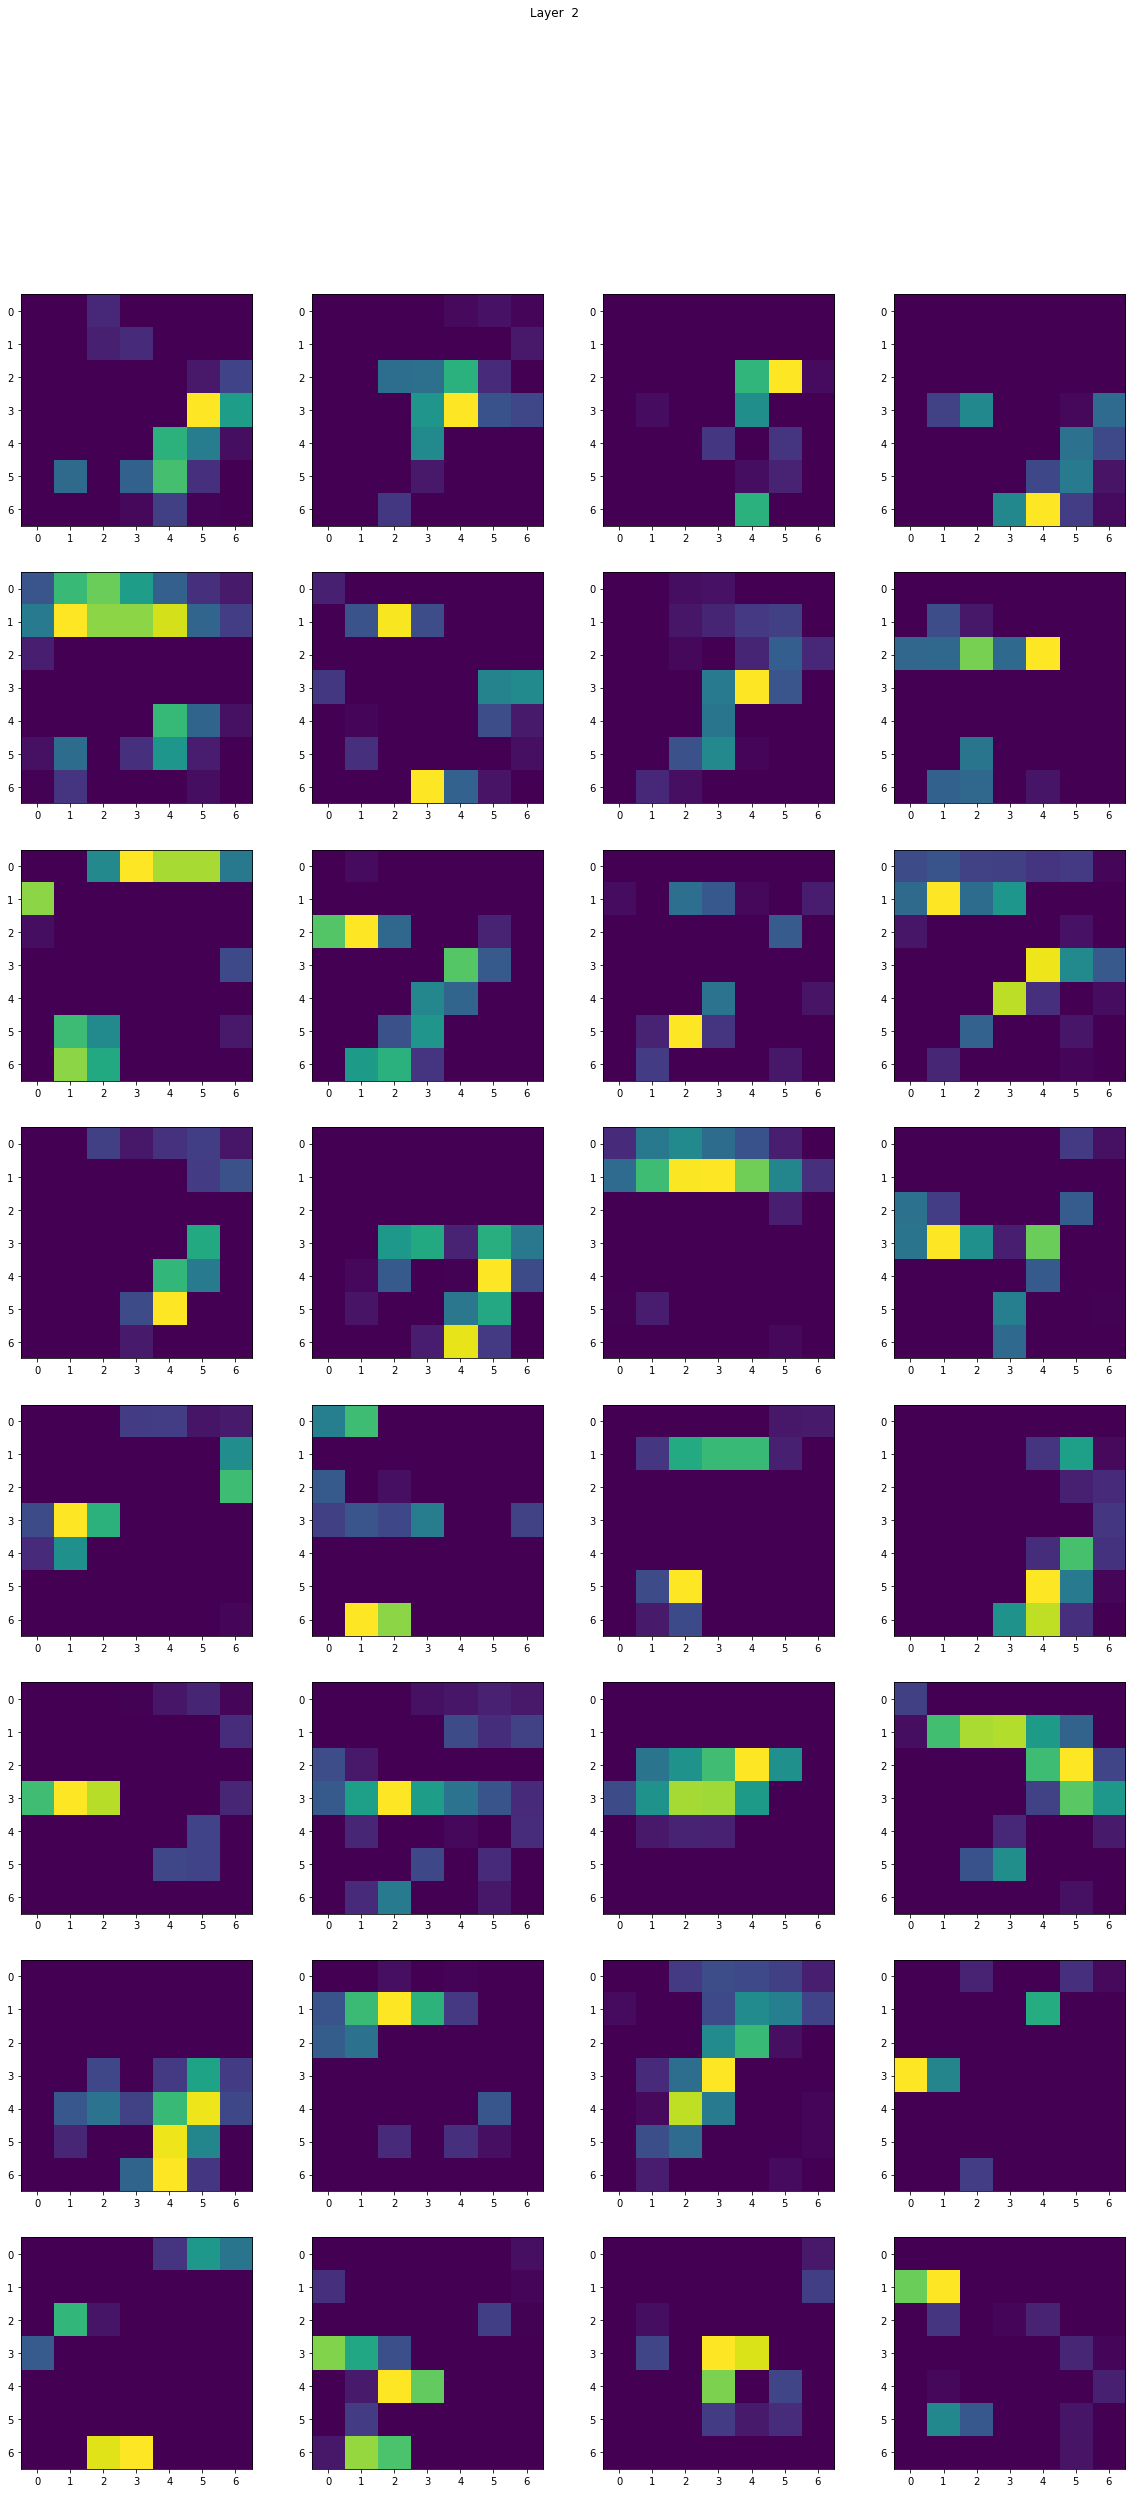

In [ ]:
image=0
for ilayer in [2]:
    plt.figure()
    n=len(figures_relu[ilayer])
    fig,ax=plt.subplots(int(n/4),4,figsize=(20,int(n/4)*5))
    fig.suptitle('Layer  '+str(ilayer))
    c=0
    for ich in range(n):
        _=ax[c//4,c%4].imshow(figures_relu[ilayer][ich][image,...])
        c+=1

# 2. WHERE IS MY NETWORK LOOKING ?

We all know that the gradients of the loss with respect to the weights are what is evaluated in the backpropagation algorithm :

$$dw=\frac{\partial L}{\partial w}$$

, where $L$ is the loss function. If we call:

- $O$ the final output of the Neural Net ;
- $I$ its input ;

we can consider the Neural Net as providing a mapping $O(I)$. We can evaluate:

$$G=\frac{\partial O}{\partial I}$$.

If the output has dimensions $m$ and the input dimensions $n$, this is a quantity:

- that depends on the input image ;
- of dimensions $ m\times n$ ;

Evaluating $G$ e are computing *how much the output changes with respect to changes in the input*. We have two scenarios:

- The gradient $G_{m,n}$ is low. This means that the output $m$ does not care much about what is happening at feature $n$

- The gradient $G_{m,n}$ is high. This means that the output $m$ is detecting something relevant at feature $n$, that is affecting its decision

Therefore, by looking at where the gradient is high we are understanding "something" about our Neural Net.

Let's try to implement this into Tensorflow 2 !

In [ ]:
results=[]
inp = tf.constant(x_val[:15,...])  # create tf constant tensor

with tf.GradientTape() as tape:  # gradient tape for gradint evaluation
  tape.watch(inp)  # take inp as variable
  preds = model(inp) # evaluate model output
  
results=preds.numpy()
grads = tape.batch_jacobian(preds, inp) 
grads = grads.numpy()

Since the dimension of the gradients is the same as the dimension of the inputs, we can visualize the gradients as images.

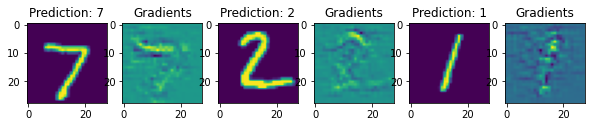

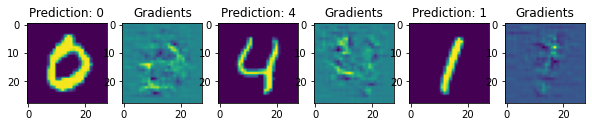

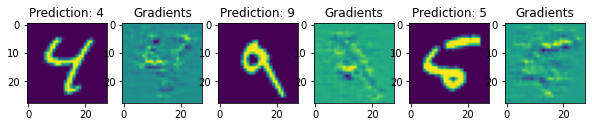

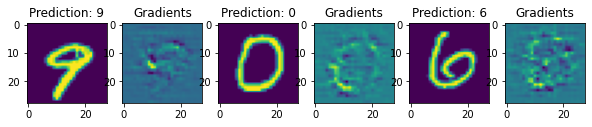

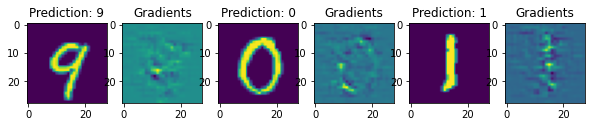

In [ ]:
c=0
for i in range(int(15/3)):
  fix,axes=plt.subplots(1,6,figsize=(10,30))
  for k in range(3):
      pred=np.argmax(results[c+k,:])
      axes[2*k].set_title(f'Prediction: {pred}')
      axes[2*k].imshow(x_val[c+k,...,0])
      axes[2*k+1].imshow(grads[c+k,pred,:,:,0])
      axes[2*k+1].set_title('Gradients')
  c+=3

There are many other interesting applications of these gradients, e.g. https://arxiv.org/pdf/1906.10670.pdf

# EXERCISE #1: Explore internal activations

In this exercise you have to explore internal activations different than the ones proposed up to now, which were referring to the convolutional layer. 

In particular you should:

- Save the activations of the dense layer on the training dataset in a numpy array ; 

- Plot the mean and average of this activations for each class separately. Are they distiguishable ?

- Try to perform a clustering on the activation using at least two clustering techniques ( E.g. try KMeans and plot the Silouhette score asa function of the number of clusters, or use UMAP )

A technique to detect outliers explores the distributions that you have visualized.

# EXERCISE #2: Am I looking in the right place ?

In this exercise you will interact with some external code. Here you find an example of a classification model:

https://www.tensorflow.org/tutorials/images/classification

Your task is to:
  
- Run the code and understand the most important parts. Please stop after the first version of the model (without dropout and data-augmentation). Even if the model is not perfect, we will use it for our purposes.

- Perform a gradient analysis of the result, as we did for the MNIST model and visualize it for a set of images ;

If you finish much before the time, you can start looking at a different gradient analysis, the Grad-Cam ( EXERCISE #3)



# EXERCISE #3 (FOR HOME ??? ): Grad-Cam ?

Grad-Cam is similar in spirit to gradient analysis. https://arxiv.org/pdf/1610.02391.pdf , but the analysis is performed closer to the output and also the value of activations play a role.

The last convolutional layer of dimension $n_x,n_y,n_{ch}$ is chosen, with activations $A^{k}_{ij},i=1...n_x,j=1...n_y$, and a class $c$ with score (output) $y^c$ fixed.

For each channel a derivative is evaluated:

$$\alpha^c_k=Mean_{i,j}  \frac{\partial y^c}{\partial A^k_{i,j}}$$ 

and the Grad-Cam image is than evaluated as:

$$GC^c_{i,j}=ReLU \left( \sum_k \alpha^c_k A^{k}_{ij} \right)$$.

Notive that this produces an image of dimension $n_x \times n_y$, that must be upscaled to recover again the resolution of the initial image.

This exercise is a continuation of Ex 2. You should implement the Grad-Cam and see how different a visualization you obtain from the standard gradient analysis.

TIP: once you have the GC image you may want to use a similar code to visualize it:

In [ ]:
gc /= gc.max()
gc = cv2.resize(gc, (180,180))
gc = gc *255
gc = np.clip(gc, 0, 255).astype(np.uint8)
gc = cv2.applyColorMap(gc, cv2.COLORMAP_HOT)
ax.imshow(gc)